<h1>CS4618: Artificial Intelligence I</h1>
<h1>Accuracy Estimation</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris

In [3]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "." 

<h1>Error Estimation for Classifiers</h1>
<ul>
    <li>Recall we want to know how well a model will do in practice, once we start to use it to make predictions.
        <ul>
            <li>For regression, this is called <b>error estimation</b>. 
            </li>
            <li>For classification, you can call it 'error estimation', but we also call it
                <b>accuracy estimation</b>.
            </li>
        </ul>
    </li>
    <li>We discussed the importance of doing error estimation on a separate test set.</li>
    <li>We also saw that the performance measure we use for error estimation might be different
        from the loss function we used when training the model.
        <ul>
            <li>For regression, the loss function is often MSE, but we might use MAE (or RMSE or the $R^2$ score)
                for error estimation.
            </li>
           <li>For classification, the loss function is often cross-entropy (see later lecture), but we might use
               <b>accuracy</b> for error estimation.
            </li>
        </ul>
    </li>
</ul>

<h1>Accuracy</h1>
<ul> 
    <li>Accuracy is the obvious performance measure for a classifier: the ratio of the number of correct 
        predictions to the number of predictions made.
    </li>
    <li>If you like notation:
        $$\frac{1}{|T|}\sum_{i = 1}^{|T|} I(\hat{y}^{(i)} = y^{(i)})$$
        where $T$ is the set of examples on which you are testing the classifier and hence $|T|$ is 
        the number of examples, and $I(p)$ is the indicator function that outputs 1
        if predicate $p$ is true and zero otherwise.
    </li>
    <li>There are, however, numerous other measures that we could use instead, or as well. If we had more time,
        we might study precision, recall, F1, Area Under the Curve (AUC), and lots more.
        However, beware of 'fishing expeditions':
        <ul>
            <li>You should choose a measure or two in advance of running any experiments &mdash; 
                the measure(s) that you think are best-aligned to your business problem.
            </li>
            <li>When there are many measures, there is a temptation to calculate them all and then get excited when
                the learner performs well on one of them.
            </li>
        </ul>
    </li>
</ul>

<h2>The Limitations of Classification Accuracy</h2>
<ul>
    <li>Accuracy summarizes overall performance in a single figure, which is a good thing.</li>
    <li>But it has at least three problems:   
        <ol>
            <li>
                Giving only a single figure hides information about how the classifier performs on the individual 
                classes.
                <ul>
                    <li>This problem becomes more acute when the costs of different kinds of misclassification 
                        are not equal.
                    </li>
                    <li>For example, in email classification, it is more serious to misclassify ham as spam.
                    </li>
                    <li>In principle, we could assign costs to the different kinds of mis-classification and define
                        a cost-sensitive variant of classification accuracy, but, in practice, it's difficult, if
                        not impossible, to come up with the costs; for example, how much worse is it to 
                        classify ham as spam than spam as ham?
                    </li>
                </ul>
            </li>
            <li>
                Classification accuracy is also best when the distribution of classes in $T$ is reasonably
                balanced.
                <ul>
                    <li>
                        If, on the other hand, some of the classes are more prevalent than others, then they 
                        tend to bias the measure, e.g. if you do well on the more prevalent classes, then you get 
                        a higher score overall.
                    </li>
                </ul>
            </li>
            <li>Accuracy does not take into account correct classifications from mere chance.
                <ul>
                    <li>There are performance measures that <em>correct for chance</em>
                        (but we won't look at them!)
                    </li>
                </ul>
            </li>
        </ol>       
    </li>
    <li>Computing a <b>confusion matrix</b> can help with the first problem.</li>
    <li>Comparing with a <b>majority-class classifier</b> can help with the second and third problems.</li>
</ul>

<h1>The Confusion Matrix</h1>
<ul>
    <li>
        The <b>confusion matrix</b> $CM$ for a classifier is a square $|C| \times |C|$ matrix.
        <ul>
            <li>In a confusion matrix, a cell $CM[i, j]$
                contains the number of test examples of class $i$ that were classified as class $j$.
            </li>
        </ul>
    </li>
    <li>
        Here are examples of confusion matrices for a binary classifier and a multiclass classifier:
        <div>
            <table style="float: left; ">
                <tr>
                    <th colspan="2" rowspan="2"></th>
                    <th colspan="2">Predicted Class</th>
                </tr>
                <tr>
                    <th style="border-bottom: 1px solid black">0</th><th style="border-bottom: 1px solid black">1</th>
                </tr>
                <tr>
                    <th rowspan="2">Actual Class</th><th style="border-right: 1px solid black">0</th><td>25</td><td>10</td>
                </tr>
                <tr>
                    <th style="border-right: 1px solid black">1</th><td>20</td><td>45</td>
                </tr>
            </table>
            <table>
                <tr>
                    <th colspan="2" rowspan="2"></th><th colspan="3">Predicted Class</th>
                </tr>
                <tr>
                    <th style="border-bottom: 1px solid black">0</th><th style="border-bottom: 1px solid black">1</th><th style="border-bottom: 1px solid black">2</th>
                </tr>
                <tr>
                    <th rowspan="3">Actual Class</th><th style="border-right: 1px solid black">0</th><td>10</td><td>0</td><td>15</td>
                </tr>
                <tr>
                    <th style="border-right: 1px solid black">1</th><td>5</td><td>30</td><td>10</td>
                </tr>
                <tr>
                    <th style="border-right: 1px solid black">2</th><td>5</td><td>5</td><td>20</td>
                </tr>
            </table>
        </div>
    </li>
    <li>Let's assume a test set $T$.
        <ul>
            <li>
                The sum of all entries in $CM$ equals $|T|$.
            </li>
            <li>
                The sum of the entries in <em>row</em> $i$ is
                the number of examples in $T$ that have class $i$.
            </li>
            <li>
                The sum of the entries in <em>column</em> $j$ is
                the number of examples in $T$ that the classifier assigns to class $j$.
            </li>
            <li>
                Entries on the main diagonal, $CM[i,i]$, are correctly classified, and so $\sum_i CM[i,i]$ is
                the total number of correctly classified examples.
            </li>
            <li>
                Entries off the main diagonal, $CM[i, j], i\neq j$, are incorrectly classified, and so 
                $\sum_i\sum_{j, j \neq i} CM[i,j]$ is the total number of incorrectly classified examples.
            </li>
        </ul>
    </li>
    <li>So, in a word, what does this calculate?
        $$\frac{\sum_i CM[i,i]}{|T|}$$
    </li>
</ul>

<h2>Class exercise</h2>
<ul>
    <li>Classifier A and classifier B have the same classification accuracy (0.6) but which classifier would you use?</li>
</ul>
        <table style="float: left">
            <tr>
                <th colspan="2" rowspan="2">Classifier A</th><th colspan="2">Predicted Class</th>
            </tr>
            <tr>
                <th style="border-bottom: 1px solid black">Benign</th><th style="border-bottom: 1px solid black">Malignant</th>
            </tr>
            <tr>
                <th rowspan="2">Actual Class</th><th style="border-right: 1px solid black">Benign</th><td>400</td><td>100</td>
            </tr>
            <tr>
                <th style="border-right: 1px solid black">Malignant</th><td>300</td><td>200</td>
            </tr>
         </table>
         <table>
             <tr>
                 <th colspan="2" rowspan="2">Classifier B</th><th colspan="2">Predicted Class</th>
             </tr>
             <tr>
                 <th style="border-bottom: 1px solid black">Benign</th><th style="border-bottom: 1px solid black">Malignant</th>
             </tr>
             <tr>
                 <th rowspan="2">Actual Class</th><th style="border-right: 1px solid black">Benign</th><td>200</td><td>300</td>
             </tr>
             <tr>
                 <th style="border-right: 1px solid black">Malignant</th><td>100</td><td>400</td>
             </tr>
         </table>

<h2>Confusion Matrices in scikit-learn</h2>
<ul>
    <li>scikit-learn can produce a confusion matrix:
        <ul>
            <li>call <code>confusion_matrix</code>.</li>
        </ul>
        An example comes later.
    </li>
</ul>

<h1>Majority-Class Classifier</h1>
<ul>
    <li>
        Consider $T$ that contains 950 positive examples and 50 negative examples.
    </li>
    <li>An extremely effective classifier in terms of accuracy for this $T$ is the so-called 
       <b>majority-class classifier</b>,
       <ul>
           <li>It <em>always</em> predicts the majority class.</li>
       </ul>
    <li>In this example, it predicts the positive class, and its accuracy is very high: 0.95.</li>
    <li>But it isn't really a good classifier: it has no ability to discriminate between
        positive and negative examples.
    </li>
    <li>Many people compare the accuracy of their classifier(s) against the 
        accuracy of the majority-class classifier to check that they are doing better
        than this simple-minded <b>baseline</b>.
        <ul>
            <li>It is one way of partly overcoming the second and third problems on the earlier slide.</li>
        </ul>
    </li>
</ul>

<h2>Majority-class classifier in scikit-learn</h2>
<ul>
    <li>scikit-learn has a<code>DummyClassifier</code> class.</li>
    <li>An example comes later.</li>
</ul>

<h2>Exercise</h2>
<ul>
    <li>The majority-class classifier is a 'baseline' that we can compare against when evaluating a classifier.</li>
    <li>Propose a baseline that you can compare against when evaluating a regressor.</li>
    <li>Is it in scikit-learn?</li>
    <li>Why is the $R^2$ score relevant to this discussion?</li>
</ul>

<h1>Stratification</h1>
<ul>
    <li>Holdout (and many other methods) rely on <em>randomly</em>
        partitioning a dataset into a training set and a validation set and/or a test set
        <ul>
            <li>We've discussed before that the split may be 'lucky' or 'unlucky', hence resampling methods
                such as $k$-Fold Cross-Validation.
            </li>
        </ul>
    </li>
    <li>But there is an additional problem in the case of classification.</li>
    <li>In the case of classification, the split might not reflect
        the distribution of examples within the classes:
        <ul>
            <li>Examples of one class might be under-represented in the training set or test set.</li>
            <li>Examples of one class might even be completely absent from the training set or test set.</li>
        </ul>
    </li>
    <li><b>Stratification</b> is the solution to this: 
        <ul>
            <li>In stratification, the proportion of examples of each class in the overall dataset is respected 
                in the partitioning into training and validation/test sets
            </li>
            <li>Here's pseudocode for <b>stratified holdout</b>. For simplicity, the pseudocode only 
                covers the case of binary classification:
                <ul style="background: lightgrey">
                    <li>Divide the dataset into positive examples, $P$, and negative examples, $N$</li>
                    <li>Randomly partition $P$ into $\mathit{Train}_P$ and $\mathit{Test}_P$</li>
                    <li>Randomly partition $N$ into $\mathit{Train}_N$ and $\mathit{Test}_N$</li>
                    <li>$\mathit{Train} \gets \mathit{Train}_P \cup \mathit{Train}_N$</li>
                    <li>$\mathit{Test} \gets \mathit{Test}_P \cup \mathit{Test}_N$</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Although this fixes the distribution with respect to the classes, you may still get 'lucky' or 'unlucky' 
        in other ways. So you will still want a large dataset for holdout. And if you don't have a large enough
        dataset, then do the above multiple times, e.g. <b>Stratified 
        $k$-Fold Cross-Validation</b>.
    </li>
</ul>

<h2>Stratification in scikit-learn</h2>
<ul>
    <li>For the <code>train_test_split</code> function, there is a <code>stratify</code> argument.</li>
    <li>Corresponding to the <code>ShuffleSplit</code> class, there is a <code>StratfiedShuffleSplit</code>
        class.
    </li>
    <li>Corresponding to the <code>KFold</code> class, there is a <code>StratifiedKFold</code> class.</li>
    <li>If you use the shorthand for $k$-fold cross-validation (e.g. <code>cv=10</code>) then, for 
        classifiers, you will get stratified $k$-fold cross-validation.
    </li>
    <li>There are examples below.</li>
</ul>

<h1>Case Study: the CS1109 Dataset</h1>

In [4]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_cs1109.csv"))

In [5]:
# Split off the test set: 20% of the dataset. Note the stratification
dev_df, test_df = train_test_split(df, train_size=0.8, stratify=df["outcome"], random_state=2)

In [6]:
# The features
features = ["lect", "lab", "cao"]

In [7]:
# Create the preprocessor
preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), features)],
        remainder="drop")

In [8]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["outcome"])
dev_y = label_encoder.transform(dev_df["outcome"])
test_y = label_encoder.transform(test_df["outcome"])

In [9]:
# Let's see how a majority-class classifier performs.
# This is our baseline. We need to do better than this!

maj = DummyClassifier()
maj.fit(dev_X, dev_y)
accuracy_score(test_y, maj.predict(test_X))

0.6086956521739131

In [10]:
# In the next cell, note the use of scoring="accuracy".
# And note that cv=10 is automatically stratified k-fold cross-validation.

# We'll just try kNN and LogisticRegression.
# We could also do Logistic Regression with L1-regularization, Logistic Regression with 
# L2-regularization and any number of other classifiers to be found in scikit-learn.

In [11]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsClassifier())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="accuracy", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 10}, np.float64(0.7584656084656084))

In [12]:
# Create a pipeline that combines the preprocessor with logistic regression
logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression())])

# Create the grid search object which will find the best hyperparameter values based on validation error
np.mean(cross_val_score(logistic, dev_X, dev_y, scoring="accuracy", cv=10))

np.float64(0.7808201058201057)

In [13]:
# Both are much better than the majority-class classifier.
# But not much different from each other.
# We can check for under/overfitting

In [14]:
knn.set_params(**knn_gs.best_params_) 
scores = cross_validate(knn, dev_X, dev_y, cv=10, 
                        scoring="accuracy", return_train_score=True)
print("Training accuracy: ", np.mean(scores["train_score"]))
print("Validation accuracy: ", np.mean(scores["test_score"]))

Training accuracy:  0.7936535589845694
Validation accuracy:  0.7584656084656084


In [15]:
# knn may be overfitting a little. So we'll reject kNN.
# The other one does not overfit (not shown).
# So let's evaluate it on the test set.

In [16]:
# Re-train Logistic Regression on train+validation and test on the test set

logistic.fit(dev_X, dev_y)
accuracy_score(test_y, logistic.predict(test_X))

0.8115942028985508

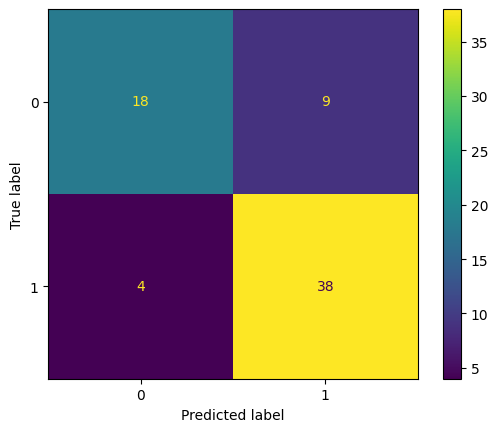

In [17]:
# If we care about one kind of error more than another, we can look at a confusion matrix

cm = confusion_matrix(test_y, logistic.predict(test_X), labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic.classes_)
disp.plot()
plt.show()

In [18]:
# Here Logistic Regression seems to predict better for people who pass.

# Anyway, now decide whether to deploy.
# If yes, then train on the entire dataset (not shown).

<h1>Case Study: the Iris Dataset</h1>
<ul>
    <li>The famous Iris dataset was created by the even more (in)famous statistician, Ronald Fisher
        (Fisher, R.A. "The use of multiple measurements in taxonomic problems", Annual Eugenics, 7, Part II, 
        179-188, 1936).
    </li>
    <li>It is available all over the web now, especially the following dataset repository:
        <a href="https://archive.ics.uci.edu/ml/datasets/iris">https://archive.ics.uci.edu/ml/datasets/iris</a>
    </li>
    <li>But, we don't need to download it. scikit-learn has a copy and a function to load it.</li>
    <li>Details:
        <ul>
            <li>$m = 150$ examples: each one is a flower &mdash; in fact, an Iris.</li>
            <li>$n = 4$ features: sepal length, sepal width, petal length and petal width (all in centimetres).</li>
            <li>Three classes (different kinds of Iris): <i>Iris setosa</i>, <i>Iris versicolor</i> and
                <i>Iris virginica</i>
                <img src="images/irises.png" />
            </li>
            <li>Big warning: 
                <ul>
                    <li>In most versions, the dataset is sorted: 50 setosa then 50 versicolor then 50 virginica.</li>
                    <li>So shuffling is important.</li>
                </ul>
            </li>
        </ul>
     </li>
</ul>

In [19]:
# Load the dataset (a dictionary) and get the features DataFrame and target values from the dictionary
iris = load_iris(as_frame=True)
df = iris.data
y = iris.target

# Shuffle the features and the target values in the same way
idx = np.random.permutation(df.index)
df.reindex(idx)
y.reindex(idx)
df.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [20]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [21]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [22]:
# Summary statistics
df.describe(include="all")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [23]:
# Looks at class distribution
y.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [24]:
# Split off the test set: 20% of the dataset.
dev_df, test_df, dev_y, test_y = train_test_split(df, y, train_size=0.8, stratify=y, random_state=4)

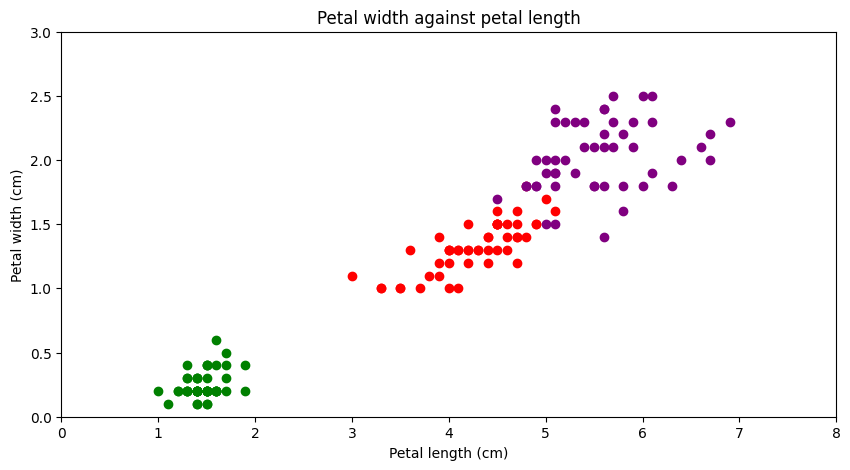

In [25]:
# Plot two of the features and the class label

plengths = df["petal length (cm)"]
pwidths = df["petal width (cm)"]

fig = plt.figure(figsize=(10,5))
plt.title("Petal width against petal length")
plt.scatter(plengths[y==0], pwidths[y==0], color = "green")
plt.scatter(plengths[y==1], pwidths[y==1], color = "red")
plt.scatter(plengths[y==2], pwidths[y==2], color = "purple")
plt.xlabel("Petal length (cm)")
plt.xlim(0, 8)
plt.ylabel("Petal width (cm)")
plt.ylim(0, 3)
plt.show()

In [26]:
# What do you notice from the diagram? 

In [27]:
# Create the preprocessor
preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), df.columns)],
        remainder="drop")

In [28]:
# We don't need a majority-class classifier.
# We know that predicting one class all the time will get 1/3 correct.
# This is our baseline. We need to do better than this!

In [29]:
# This time we'll compare different kinds of Logistic Regression - without and with L2 regularization
# - Multinomial Logistic Regression
# - Multinomial Logistic Regression with L2-regularization

In [30]:
# Create a pipeline that combines the preprocessor with logistic regression with no regularization
logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression(penalty=None))])

# We don't need a grid search because we're not regularizing, so we don't have that hyperparameter.

# Get the validation error
np.mean(cross_val_score(logistic, dev_df, dev_y, scoring="accuracy", cv=10))

np.float64(0.975)

In [31]:
# Create a pipeline that combines the preprocessor with logistic regression with L2-regularization
logisticL2 = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression(solver="saga", penalty="l2"))])

# Create a dictionary of hyperparameters for ridge regression
logisticL2_param_grid = {"predictor__C": [0.1, 0.3, 0.5],}

# Create the grid search object which will find the best hyperparameter values based on validation error
logisticL2_gs = GridSearchCV(logisticL2, logisticL2_param_grid, scoring="accuracy", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
logisticL2_gs.fit(dev_df, dev_y)

# Let's see how well we did
logisticL2_gs.best_params_, logisticL2_gs.best_score_

({'predictor__C': 0.3}, np.float64(0.9416666666666667))

In [32]:
# Let's pick plain Logistic Regression with no regularization.

# Re-train it on train+validation and test on the test set

logistic.fit(dev_df, dev_y)
accuracy_score(test_y, logistic.predict(test_df))

0.9333333333333333

In [33]:
# Now decide whether to deploy.
# If yes, then train on the entire dataset (not shown).

<ul>
    <li>For those of you whose machine learning work is not confined to this module, I recommend this paper, which
        (happily) agrees with everything I've taught you and even goes a bit further:<br />
        Michael A. Lones (2021): <i>How to avoid machine learning pitfalls: a guide for academic researchers</i>.
        <a href="https://arxiv.org/abs/2108.02497">https://arxiv.org/abs/2108.02497</a>
</ul>